In [123]:
from math import factorial
import numpy as np
import pickle
import matplotlib.pyplot as plt
from scipy.special import eval_hermite as hermite
from PIL import Image
import pandas as pd
from matplotlib.colors import LogNorm
from scipy.optimize import curve_fit
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.patches as patches

import finesse
import scipy.fftpack as sfft
from finesse.gaussian import HGMode

finesse.configure(plotting=True)
CB_color_cycle = ['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00']

Starting at the $z=0$ plane with field distribution $U\left(x^{\prime}, y^{\prime}, 0\right)$, two-dimensional Fourier transform the field distribution to get the angular spectrum:
$$
A\left(k_{x}, k_{y} ; 0\right) = \int_{-\infty}^{\infty} \int_{-\infty}^{\infty} U\left(x^{\prime}, y^{\prime}, 0\right) e^{-\left(k_{x} x^{\prime}+k_{y} y^{\prime}\right) i} \mathrm{~d} x^{\prime} \mathrm{dy}^{\prime} = \mathscr{F}\left( U\left(x, y, 0\right) \right)
$$

The field after propagating a distance $L$
$$
U(x, y, L)=\int_{-\infty}^{\infty} \int_{-\infty}^{\infty} A\left(k_{x}, k_{y} ; 0\right) e^{- k_{z} L} e^{\left(k_{x} x+k_{y} y\right) i} \mathrm{~d} k_{x} \mathrm{~d} k_{y} = \mathscr{F}^{-1}\left(A\left(k_{x}, k_{y} ; 0\right) e^{- i k_{z} L} \right)
$$

$$
k_{z}=\sqrt{k^{2}-k_{x}^{2}+k_{y}^{2}}, \,\,\, \\
k=\frac{2 \pi}{\lambda}
$$




(28.246850458110643+0j)
1.0
(6.373097205500119e-13+0j)


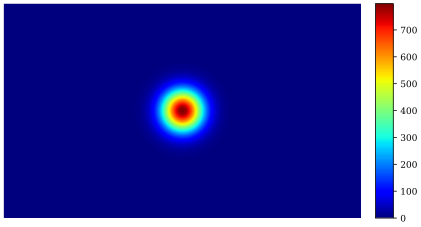

In [33]:
l = 9.2e-6
cx = int(1920/2)
cy = int(1152/2)
wx0 = 1000e-6
wy0 = 1000e-6

q_x0 = 1j*np.pi*wx0**2/(1064e-9)
q_y0 = 1j*np.pi*wy0**2/(1064e-9)
HG00_0 = HGMode((q_y0, q_x0), n=0, m=0)
x = np.arange(-cx, cx)*l
y = np.arange(-cy, cy)*l
HG00_0_data = HG00_0.unm(y, x)

fig, ax = plt.subplots(figsize=(7,5))

im = ax.imshow(np.abs(HG00_0_data), cmap="jet") #norm=LogNorm(vmin=0, vmax=20))
plt.grid(False)
plt.axis("off")

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.2)
cbar = fig.colorbar(im, cax=cax,);
# fig.savefig('./1009/HG00_SLM.png', bbox_inches='tight', dpi=120, pad_inches=0.01);

In [34]:
def phaseHG33(wphase=0.4):
    wphase1 = wphase*wx0
    wphase2 = wphase*wy0
    zero = np.sqrt(1.5)
    x0 = np.array([-zero, 0, zero])*wphase1/np.sqrt(2)
    y0 = np.array([-zero, 0, zero])*wphase2/np.sqrt(2)
    
    phaseHG33 = np.ones((1920, 1152))*np.pi
    lx = ly = l

    for i in np.arange(1920):
        for j in np.arange(1152):
            x = (i-1920/2)*lx
            y = (j-1152/2)*ly
            
            if (x0[0] < x < x0[1] and -1152*ly/2 < y < y0[0]) or (x0[2] < x < 1920*lx/2 and -1152*ly/2 < y < y0[0]) or \
            (-1920*lx/2 < x < x0[0] and y0[0] < y < y0[1]) or (x0[1] < x < x0[2] and y0[0] < y < y0[1]) or \
            (x0[0] < x < x0[1] and y0[1] < y < y0[2]) or (x0[2] < x < 1920*lx/2 and y0[1] < y < y0[2]) or \
            (-1920*lx/2 < x < x0[0] and y0[2] < y < 1152*ly/2) or (x0[1] < x < x0[2] and y0[2] < y < 1152*ly/2):
                phaseHG33[i][j] = 0
    return np.rot90(phaseHG33)

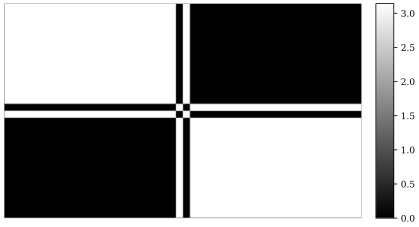

In [86]:
phaseHG33data = phaseHG33(wphase=0.4)
fig, ax = plt.subplots(figsize=(7,5))

im = ax.imshow(phaseHG33data, cmap="gray", ) #norm=LogNorm(vmin=0, vmax=20))
plt.grid(False)
plt.axis("off")

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.2)
cbar = fig.colorbar(im, cax=cax,)

rect = patches.Rectangle((0, 0), 1920, 1152, linewidth=1, edgecolor='gray', facecolor='none')
ax.add_patch(rect);

In [87]:
k = 2*np.pi/(1064e-9)

def Fourier_propagate(field_z0, dx, dy, L_dis):
    freqxs = 2*np.pi*np.fft.fftshift(np.fft.fftfreq(field_z0.shape[1], d=dx))
    freqxs = freqxs.reshape(1,-1)
    freqys = 2*np.pi*np.fft.fftshift(np.fft.fftfreq(field_z0.shape[0], d=dy))
    freqys = freqys.reshape(-1,1)

    
    HG_33_fourier = np.fft.fftshift(np.fft.fft2(field_z0, norm='forward'))
    data = HG_33_fourier*np.exp(-1j*(k**2-freqxs**2-freqys**2)**0.5*L_dis)
    HG_33_Propagated = np.fft.ifft2(data, norm='forward')

    return HG_33_Propagated

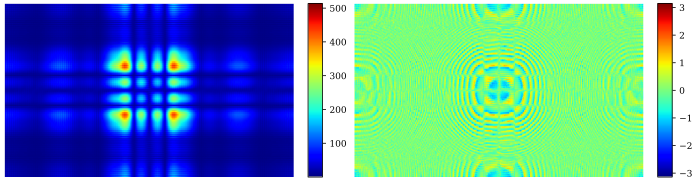

In [110]:
field_data = HG00_0_data*np.exp(1j*phaseHG33data)
dx = x[1] - x[0]
dy = y[1] - y[0]
L_dis = 1.2

HG_33_SLM = Fourier_propagate(field_data, dx, dy, L_dis)

fig, (ax, ax1) = plt.subplots(ncols=2, nrows=1, figsize=(12, 6))

im = ax.imshow(np.abs(HG_33_SLM), cmap="jet") #norm=LogNorm(vmin=0, vmax=20))
im1 = ax1.imshow(np.angle(HG_33_SLM), cmap="jet") #norm=LogNorm(vmin=0, vmax=20))

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.2)
cbar = fig.colorbar(im, cax=cax,);

divider1 = make_axes_locatable(ax1)
cax1 = divider1.append_axes("right", size="5%", pad=0.2)
cbar1 = fig.colorbar(im1, cax=cax1,);
ax.set_axis_off()
ax1.set_axis_off();
plt.subplots_adjust(wspace=0.1);

(-1.963230779906077-3.3717389406591796j)
-2503.838531014022
(-5.859722312398269e-11+7.844814092702418e-12j)

(0.9999999999998124+0j)
(0.9999999999998129+0j)


0.7174227438302964

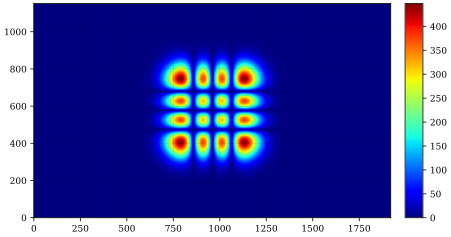

In [115]:
ratio = 0.4
q_x0 = 1j*np.pi*(wx0*ratio)**2/(1064e-9) + L_dis
q_y0 = 1j*np.pi*(wy0*ratio)**2/(1064e-9) + L_dis
HG33_0 = HGMode((q_y0, q_x0), n=3, m=3)

x = np.arange(-cx, cx)*l
y = np.arange(-cy, cy)*l
step = x[1]-x[0]
HG33_0_data = HG33_0.unm(y, x)

fig, ax = plt.subplots(figsize=(7,5))

im = ax.imshow(np.abs(HG33_0_data), cmap="jet") #norm=LogNorm(vmin=0, vmax=20))
# plt.grid(False)
# plt.axis("off")

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.2)
cbar = fig.colorbar(im, cax=cax,);

norm1 = np.sum(np.conj(HG_33_SLM)*HG_33_SLM * step * step)
norm2 = np.sum(np.conj(HG33_0_data)*HG33_0_data * step * step)
print()
print(norm1)
print(norm2)
rho_nm = np.sum(np.abs(HG_33_SLM)*np.abs(HG33_0_data) * step * step)
eta_nm = np.abs(rho_nm*np.conj(rho_nm))
eta_nm

In [117]:
phaseHG33data = phaseHG33(wphase=0.35)
field_data = HG00_0_data*np.exp(1j*phaseHG33data)
HG_33_SLM_035 = Fourier_propagate(field_data, dx, dy, L_dis)

phaseHG33data = phaseHG33(wphase=0.4)
field_data = HG00_0_data*np.exp(1j*phaseHG33data)
HG_33_SLM_040 = Fourier_propagate(field_data, dx, dy, L_dis)

phaseHG33data = phaseHG33(wphase=0.45)
field_data = HG00_0_data*np.exp(1j*phaseHG33data)
HG_33_SLM_045 = Fourier_propagate(field_data, dx, dy, L_dis)

In [122]:
ratios = np.linspace(0.3, 0.5, 100)
eta_33_w035s = []
eta_33_w040s = []
eta_33_w045s = []
for ratio in ratios:
    q_x0 = 1j*np.pi*(wx0*ratio)**2/(1064e-9) + L_dis
    q_y0 = 1j*np.pi*(wy0*ratio)**2/(1064e-9) + L_dis
    HG33_0 = HGMode((q_y0, q_x0), n=3, m=3)

    HG33_0_data = HG33_0.unm(y, x)
    rho_33 = np.sum(np.abs(HG_33_SLM_035)*np.abs(HG33_0_data) * step * step)
    eta_33 = np.abs(rho_33*np.conj(rho_33))
    eta_33_w035s.append(eta_33)

    rho_33 = np.sum(np.abs(HG_33_SLM_040)*np.abs(HG33_0_data) * step * step)
    eta_33 = np.abs(rho_33*np.conj(rho_33))
    eta_33_w040s.append(eta_33)

    rho_33 = np.sum(np.abs(HG_33_SLM_045)*np.abs(HG33_0_data) * step * step)
    eta_33 = np.abs(rho_33*np.conj(rho_33))
    eta_33_w045s.append(eta_33)

(0.07836634683961763-3.460304477743887j)
-1195.6310173937077
(-4.6024231031980413e-07-5.000825035426309e-08j)
(0.04397023499164132-3.4714441609882796j)
-1218.421568256364
(-3.8022840338106e-07-7.387555916825532e-08j)
(0.009171106500750037-3.4821745617344377j)
-1241.4172175922824
(-3.115672419938403e-07-8.859781171688858e-08j)
(-0.026025886810791876-3.492486863829119j)
-1264.615526794582
(-2.530490657633604e-07-9.631399082178032e-08j)
(-0.061615378258491615-3.5023722789434686j)
-1288.013964166572
(-2.0352262591837483e-07-9.876873780553725e-08j)
(-0.09759178522612366-3.5118220525803485j)
-1311.6099048451592
(-1.619080714288875e-07-9.737298150232272e-08j)
(-0.13394930825991258-3.52082747015875j)
-1335.4006307822356
(-1.2720499052254084e-07-9.325676329874519e-08j)
(-0.17068193033068657-3.5293798631709175j)
-1359.3833307852713
(-9.849660949718303e-08-8.731506686490264e-08j)
(-0.20778341626817887-3.5374706154075786j)
-1383.5551006182782
(-7.49509922274809e-08-8.024740315903853e-08j)
(-0.2452

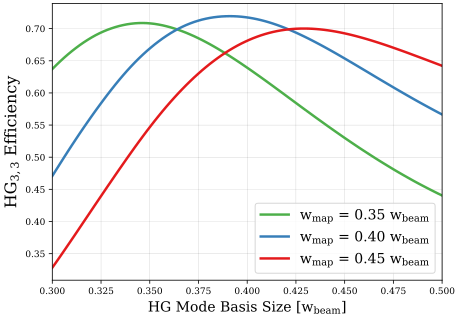

In [137]:
fig, ax = plt.subplots(figsize=(7, 5))

ax.plot(ratios, eta_33_w035s, lw=2.5, color=CB_color_cycle[2], label="w$_{\mathrm{map}}$ = 0.35 w$_{\mathrm{beam}}$")
ax.plot(ratios, eta_33_w040s, lw=2.5, color=CB_color_cycle[0], label="w$_{\mathrm{map}}$ = 0.40 w$_{\mathrm{beam}}$")
ax.plot(ratios, eta_33_w045s, lw=2.5, color=CB_color_cycle[7], label="w$_{\mathrm{map}}$ = 0.45 w$_{\mathrm{beam}}$")

ax.set_xlabel("HG Mode Basis Size [w$_{\mathrm{beam}}$]", fontsize=14, labelpad=5)
ax.set_ylabel("$\mathrm{HG}_{3,3}$ Efficiency", fontsize=16, labelpad=5);
legend = plt.legend(fontsize=14, ncols=1, loc="best");